In [18]:
!pip install roboflow opencv-python-headless scikit-learn

In [2]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [3]:
#Import Necessary Libraries
from roboflow import Roboflow
import os
import cv2
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from skimage.feature import hog


In [4]:
# Initialize Roboflow and Download the Dataset
rf = Roboflow(api_key="jiw10sHmPGagOJyGvK5b")
project = rf.workspace("research-kiwbb").project("annot-0abet")
version = project.version(1)
dataset = version.download("yolov5")

# Directories to Access Dataset
train_image_dir = os.path.join(dataset.location, "train", "images")
train_annotation_dir = os.path.join(dataset.location, "train", "labels")
test_image_dir = os.path.join(dataset.location, "valid", "images")
test_annotation_dir = os.path.join(dataset.location, "valid", "labels")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to annot-1 in yolov5pytorch:: 100%|██████████| 6698/6698 [00:00<00:00, 10750.93it/s]


In [6]:
# Define Flower Classes and Target Class ID
flower_classes = [
    "Common Lanthana", "Hibiscus", "Jatropha", "Marigold", "Rose",
    "Champaka", "Chitrak", "Honeysuckle", "Indian Mallow",
    "Malabar Melastome", "Shankupushpam", "Spider Lily", "Sunflower"
]


# Set `target_class_id = None` to include all classes in the dataset
target_class_id = 0  # Change this to select class to be detected


In [7]:
# Parse YOLO Annotations for the Selected Flower Class
def parse_yolo_annotation(annotation_path, img_width, img_height, class_id=None):
    """Parse YOLO annotations and return bounding boxes for a specific class (or all classes if class_id=None)."""
    bboxes = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            current_class_id = int(parts[0])
            if class_id is None or current_class_id == class_id:
                x_center, y_center, width, height = map(float, parts[1:])
                x_min = int((x_center - width / 2) * img_width)
                y_min = int((y_center - height / 2) * img_height)
                x_max = int((x_center + width / 2) * img_width)
                y_max = int((y_center + height / 2) * img_height)
                bboxes.append((x_min, y_min, x_max, y_max, current_class_id))
    return bboxes


In [8]:
# Prepare Dataset with a Limit and for a Specific Class
def prepare_dataset(image_dir, annotation_dir, limit=None, class_id=None):
    images, labels = [], []
    count = 0

    for annotation_path in glob.glob(os.path.join(annotation_dir, "*.txt")):
        if limit is not None and count >= limit:
            break

        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)
        if image is None:
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height, class_id)

        # Extract positive samples for the target class
        for (x_min, y_min, x_max, y_max, detected_class_id) in bboxes:
            cropped_img = image[y_min:y_max, x_min:x_max]
            resized_img = cv2.resize(cropped_img, (64, 128))
            normalized_img = resized_img.astype(np.float32) / 255.0
            images.append(normalized_img)
            labels.append(1)  # Label for the positive class (flower)

        # Add a negative sample (no flower)
        neg_sample = cv2.resize(image[0:128, 0:64], (64, 128))
        normalized_neg_sample = neg_sample.astype(np.float32) / 255.0
        images.append(normalized_neg_sample)
        labels.append(0)  # Label for the negative class (no flower)

        count += 1

    return images, labels


In [9]:
# Load Training and Testing Datasets for the Target Flower Class
train_images, train_labels = prepare_dataset(train_image_dir, train_annotation_dir, class_id=target_class_id)
test_images, test_labels = prepare_dataset(test_image_dir, test_annotation_dir, limit=5, class_id=target_class_id)


In [10]:
# Split the Training Dataset into Training and Validation Datasets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)


In [11]:
# Step 9: Initialize HOG Descriptor and Define Feature Extraction Function
hog = cv2.HOGDescriptor()

def extract_hog_features(images):
    features = []
    for i, image in enumerate(images):
        try:
            image_uint8 = (image * 255).astype(np.uint8)
            hog_feature = hog.compute(image_uint8).flatten()
            features.append(hog_feature)
        except Exception as e:
            print(f"Warning: Skipping image {i} due to error: {e}")
            continue
    return features

# Extract HOG features for training, validation, and test sets
train_features = extract_hog_features(train_images)
val_features = extract_hog_features(val_images)
test_features = extract_hog_features(test_images)


In [12]:
# Step 10: Build and Train the HOG-SVM Model with Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000]
}
grid = GridSearchCV(LinearSVC(), param_grid, cv=5)

start_time = time.time()
grid.fit(train_features, train_labels)
training_time = time.time() - start_time
print("Best parameters found: ", grid.best_params_)
print("HOG-SVM model trained successfully in {:.2f} seconds.".format(training_time))


Best parameters found:  {'C': 0.1, 'max_iter': 1000}
HOG-SVM model trained successfully in 40.42 seconds.


In [13]:
# Step 11: Evaluate Model on Validation Set
val_preds = grid.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, zero_division=1)
val_recall = recall_score(val_labels, val_preds, zero_division=1)

print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)


Validation Accuracy: 0.9938144329896907
Validation Precision: 0.9
Validation Recall: 0.9473684210526315


In [14]:
# Step 12: Evaluate Model on Test Set
test_preds = grid.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, zero_division=1)
test_recall = recall_score(test_labels, test_preds, zero_division=1)

print("Testing Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


Testing Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0


In [15]:
# Step 13: Speed Evaluation
start_time = time.time()
_ = grid.predict(test_features)  # Just for timing
detection_time = time.time() - start_time
print("Detection time for test set:", detection_time)


Detection time for test set: 0.0007166862487792969


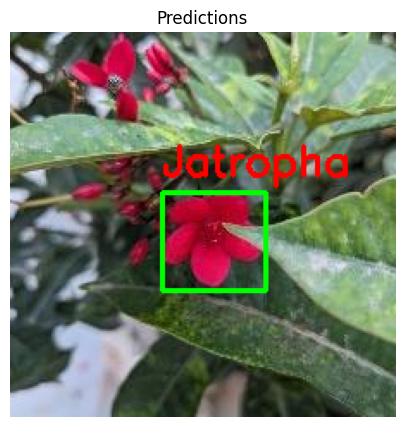

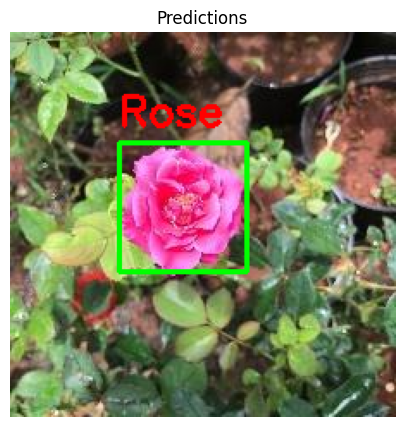

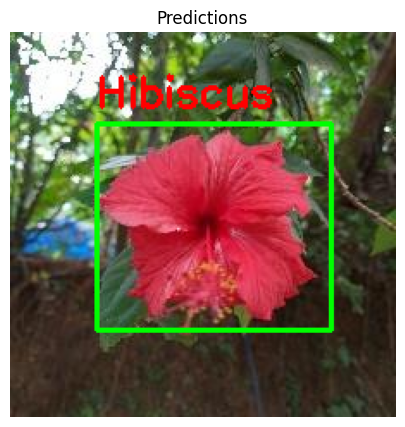

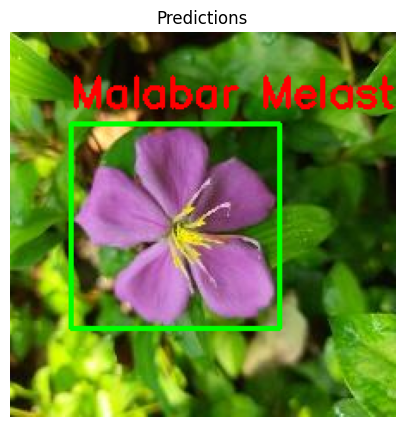

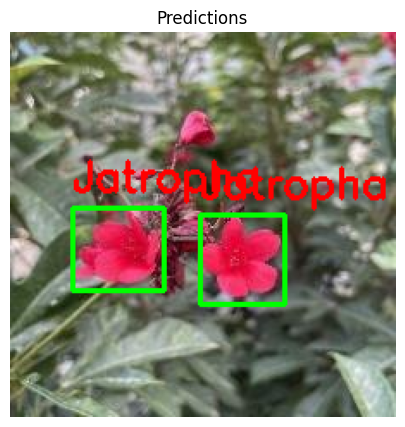

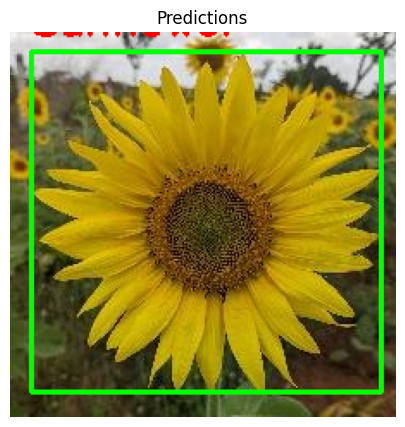

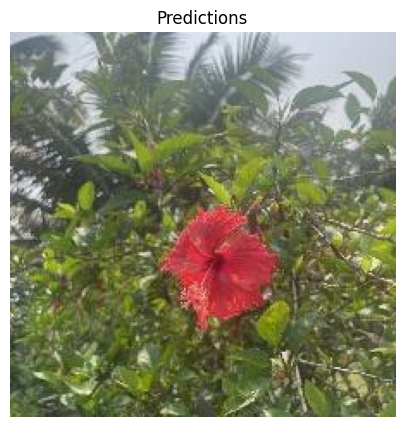

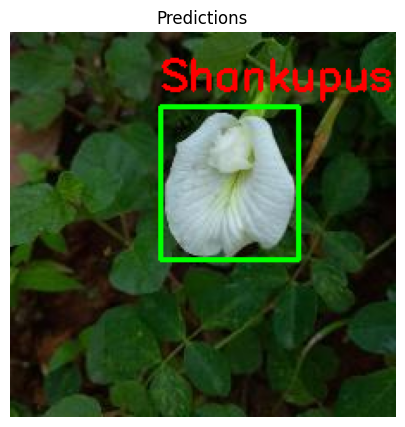

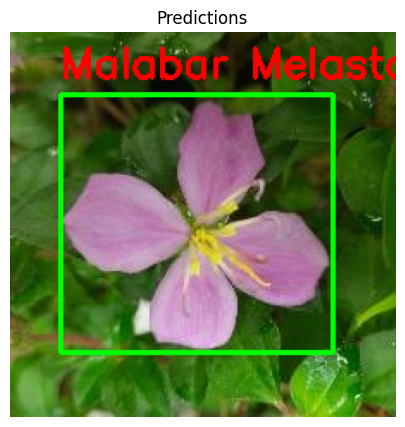

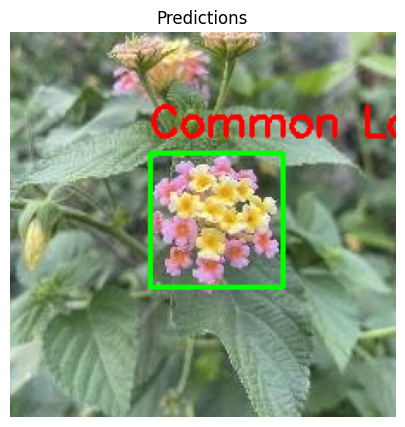

In [17]:
# Step 14: Define Visualization Function and Run Visualization
def visualize_predictions(image_dir, annotations_dir, predictions, limit=10):
    count = 0
    for annotation_path in glob.glob(os.path.join(annotations_dir, "*.txt")):
        image_path = os.path.join(image_dir, os.path.basename(annotation_path).replace('.txt', '.jpg'))
        image = cv2.imread(image_path)
        if image is None:
            continue

        img_height, img_width = image.shape[:2]
        bboxes = parse_yolo_annotation(annotation_path, img_width, img_height)

        for bbox in bboxes:
            x_min, y_min, x_max, y_max, detected_class_id = bbox
            label = flower_classes[detected_class_id]
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Predictions')
        plt.show()

        count += 1
        if count >= limit:
            break

# Run Visualization
visualize_predictions(test_image_dir, test_annotation_dir, test_preds, limit=10)
